Import

In [ ]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [ ]:
!unzip /content/drive/MyDrive/archive.zip

In [ ]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir,
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels
        im_gray = cv2.imread(imgpath, cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten()
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    return data, labels

In [ ]:
#declear path to your mnist data folder
img_path = '/content/trainingSet'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list,
                                                    label_list,
                                                    test_size=0.1,
                                                    random_state=42)

[INFO] processed 10000/42000
[INFO] processed 20000/42000
[INFO] processed 30000/42000
[INFO] processed 40000/42000


In [ ]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as
                data shards - tuple of images and label lists.
        args:
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1

    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))}

In [ ]:
#create clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [ ]:
def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

#process and batch the test set
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

In [ ]:
from keras.optimizers import learning_rate_schedule
initial_learning_rate = 0.01
comms_round = 100
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=initial_learning_rate,decay=initial_learning_rate / comms_round,momentum=0.9)

In [ ]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad




In [ ]:
def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

SGD

In [ ]:
SGD_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(y_train)).batch(320)
smlp_SGD = SimpleMLP()
SGD_model = smlp_SGD.build(784, 10)

SGD_model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

# fit the SGD training data to model
#hist_SGD for E=10, hist_SGD2 for E=50, hist_SGD3 for E=100
hist_SGD3 = SGD_model.fit(SGD_dataset, epochs=100, verbose=0,validation_data=(X_test,y_test),validation_split=0.1)

#test the SGD global model and print out metrics
for(X_test, Y_test) in test_batched:
        SGD_acc, SGD_loss = test_model(X_test, Y_test, SGD_model, 1)

132/132 [==============================] - 0s 1ms/step
comm_round: 1 | global_acc: 97.571% | global_loss: 1.4954057931900024


In [ ]:
import matplotlib.pyplot as plt

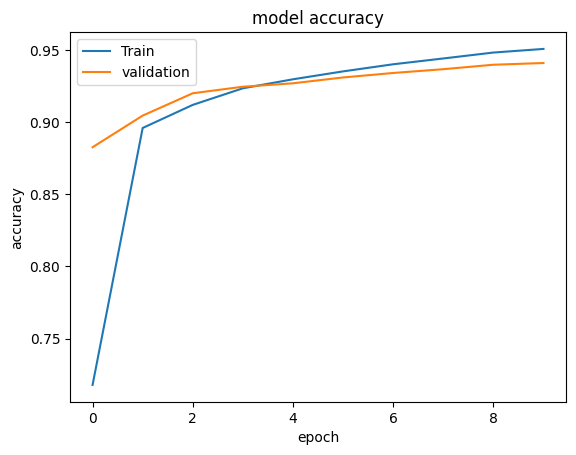

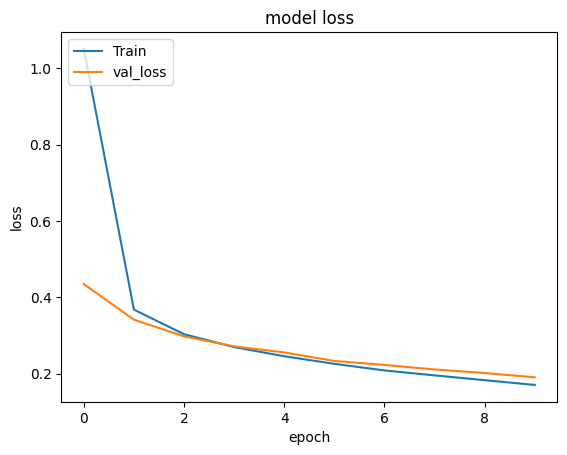

In [ ]:
#E=10
# summarize history for accuracy
plt.plot(hist_SGD.history['accuracy'])
plt.plot(hist_SGD.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_SGD.history['loss'])
plt.plot(hist_SGD.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','val_loss'], loc='upper left')
plt.show()

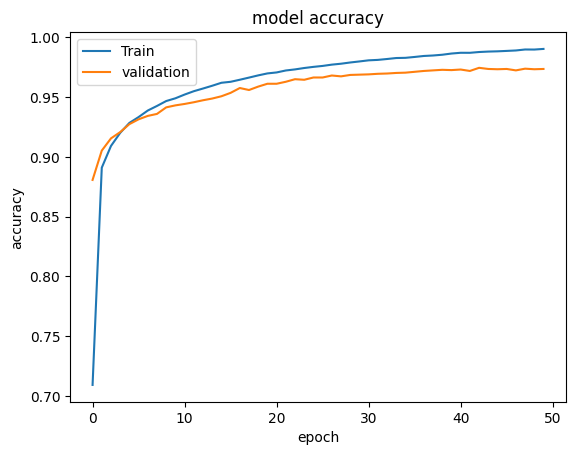

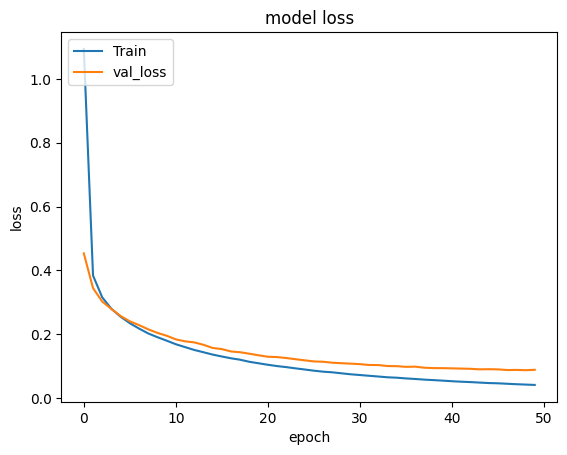

In [ ]:
#E=50
# summarize history for accuracy
plt.plot(hist_SGD2.history['accuracy'])
plt.plot(hist_SGD2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_SGD2.history['loss'])
plt.plot(hist_SGD2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','val_loss'], loc='upper left')
plt.show()

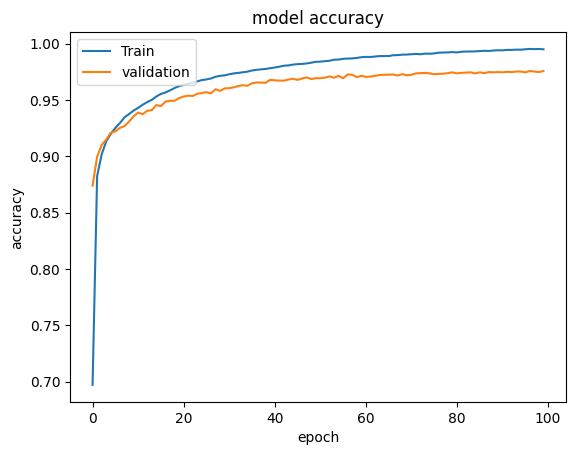

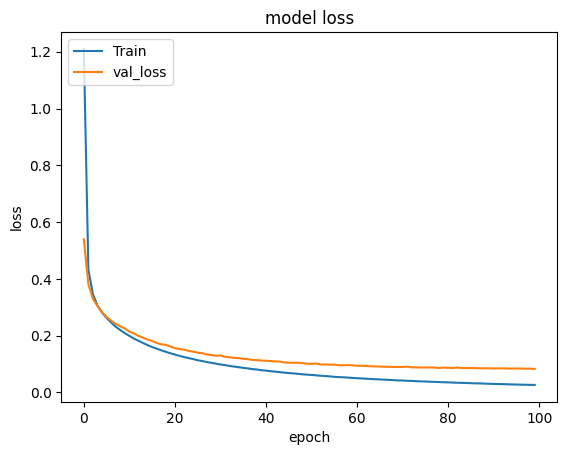

In [ ]:
#E=100
# summarize history for accuracy
plt.plot(hist_SGD3.history['accuracy'])
plt.plot(hist_SGD3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_SGD3.history['loss'])
plt.plot(hist_SGD3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','val_loss'], loc='upper left')
plt.show()

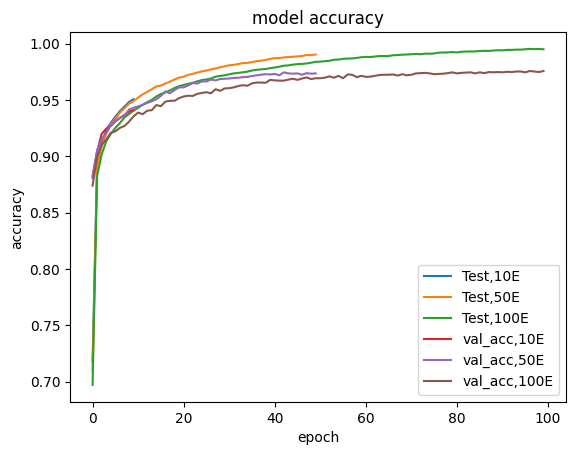

In [ ]:
#plot all in one E=10, E=50, E=100
# summarize history for accuracy
plt.plot(hist_SGD.history['accuracy'])
plt.plot(hist_SGD2.history['accuracy'])
plt.plot(hist_SGD3.history['accuracy'])
plt.plot(hist_SGD.history['val_accuracy'])
plt.plot(hist_SGD2.history['val_accuracy'])
plt.plot(hist_SGD3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Test,10E','Test,50E','Test,100E','val_acc,10E','val_acc,50E','val_acc,100E',], loc='lower right')
plt.show()


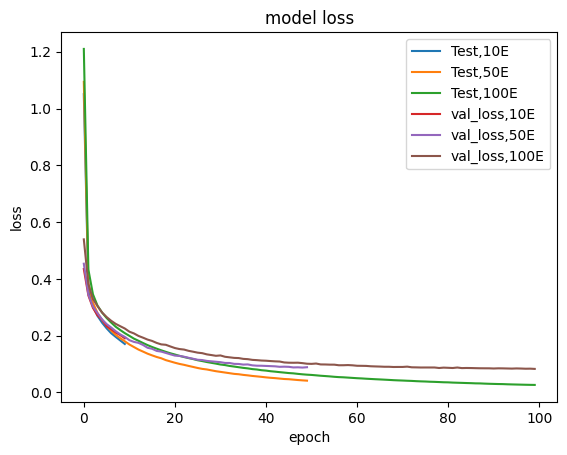

In [ ]:
#plot all in one E=10, E=50, E=100
# summarize history for loss
plt.plot(hist_SGD.history['loss'])
plt.plot(hist_SGD2.history['loss'])
plt.plot(hist_SGD3.history['loss'])
plt.plot(hist_SGD.history['val_loss'])
plt.plot(hist_SGD2.history['val_loss'])
plt.plot(hist_SGD3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','val_loss'], loc='upper left')
plt.legend(['Test,10E','Test,50E','Test,100E','val_loss,10E','val_loss,50E','val_loss,100E',], loc='upper right')
plt.show()